<a href="https://colab.research.google.com/github/joaochenriques/IST_MCTE/blob/main/StreamTurbines/BladeDesign_V03.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
import subprocess
import pandas as pd
import pathlib
import numpy as np
from scipy.optimize import minimize

def cmdcall( cmd, verbose = False ):
    output = subprocess.getoutput( cmd )
    if verbose: print(output)

if not pathlib.Path("mpl_utils.py").exists():
  cmdcall( "curl -O https://raw.githubusercontent.com/joaochenriques/ipynb_libs/main/mpl_utils.py" )

import matplotlib.pyplot as mpl
import mpl_utils as mut
mut.config_plots()

from matplotlib_inline.backend_inline import set_matplotlib_formats
set_matplotlib_formats('svg')

0.5494215145765795

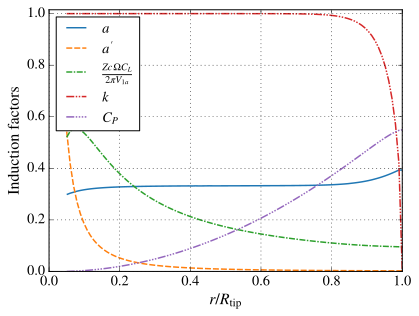

In [153]:
def tip_loss( a, ap, λr, λtip, Z ):
    ff = -0.5 * Z * ( λtip / λr - 1 ) * np.sqrt( 1 + ( λr / (1-a) )**2 )
    rr =  2.0 / np.pi * np.arccos( np.exp( ff ) )
    # rr = 1
    return rr

def f_objective( X, λr ):
    a  = X[0]
    ap = X[1]

    λtip = 10
    Z = 3
    k = tip_loss( a, ap, λr, λtip, Z )

    fO = k * ap * ( 1.0 - a ) * λr**3
    return -fO

def f_constraint( X, λr ):
    a  = X[0]
    ap = X[1]
    fC = ( 1.0 + ap ) * ap * λr**2 - ( 1.0 - a ) * a
    return fC

rad2deg = 180/np.pi
deg2rad = np.pi/180

λr_vec = []
ϕ_vec = []
a_vec = []
ap_vec = []
CP_vec = []
EE_vec = []
k_vec = []
CP_max_vec = []

X0 = ( 0.33, 0.01 )
λtip = 10.0
Z = 3

# λr_set = np.concatenate( ( np.linspace( 0.25, 2.0, 8 ), np.linspace( 2.5, 6.0, 8 ), np.linspace( 7, 12,6 ) ) )
λr_set = np.linspace( 0.5, λtip, 100 )

for i, λr in enumerate( λr_set ):
    f_objt = lambda X : f_objective( X, λr )
    f_cons = lambda X : f_constraint( X, λr )

    cons = [ { 'type': 'eq', 'fun': f_cons } ]
    sol = minimize( f_objt, X0, method = 'SLSQP', constraints = cons )
    X0 = sol.x

    a  = X0[0]
    ap = X0[1]
    k = tip_loss( a, ap, λr, λtip, Z )

    ϕ  = np.arctan( ( 1 - a ) / ( 1 + ap ) / λr )
    CP = 8 / λtip**2 * k * ap * ( 1.0 - a ) * λr**3
    EE = 4.0 * ap * λr**2 / np.sqrt( (1-a)**2 + (1+ap)**2 * λr**2 )

    λr_vec.append( λr )
    a_vec.append( a )
    ap_vec.append( ap )
    ϕ_vec.append( ϕ )
    CP_vec.append( CP )
    EE_vec.append( EE )
    k_vec.append( k )

    if i > 0:
        CP_max = CP_max_vec[i-1] + 0.5 * ( CP_vec[i-1] + CP_vec[i] ) * ( λr_vec[i] - λr_vec[i-1] )
    else:
        CP_max = 0.0

    CP_max_vec.append( CP_max )

λr_vec = np.array( λr_vec )

x_vec = λr_vec / λtip

mpl.plot( x_vec, a_vec,  label = r"$a$" )
mpl.plot( x_vec, ap_vec, label = r"$a'$" )
mpl.plot( x_vec, EE_vec, label = r"$\frac{Zc\,\Omega C_L}{2\pi V_{1a}}$" )
mpl.plot( x_vec, k_vec,  label = r"$k$" )
mpl.plot( x_vec, CP_max_vec, label = r"$C_P$" )

mpl.xlabel( r"$r/R_\mathrm{tip}$")
mpl.ylabel( "Induction factors")
mpl.legend( loc="upper left" )
# mpl.xlim( [ 0, 1.015 ] )
mpl.ylim( [ 0, 1.015 ] )
mpl.grid()
mpl.savefig( "InductionFactors.pdf" )
CP_max_vec[-1]

In [111]:
df = pd.DataFrame( { r"$\lambda_r$": λr_vec,
                     r"$a$": np.round(a_vec,decimals=5),
                     r"$a'$": np.round(ap_vec,decimals=5),
                     r"$\phi$": np.round(ϕ_vec, decimals=2)*rad2deg,
                     r"$\frac{Zc\,\Omega C_L}{2\pi V_{1a}}$": np.round(EE_vec, decimals=5)
                    } )

# print( df.to_latex(index=False,
#                   formatters={"name": str.upper},
#                   float_format="{:.5f}".format,
# ))
df

,$\lambda_r$,$a$,$a'$,$\phi$,"$\frac{Zc\,\Omega C_L}{2\pi V_{1a}}$"
0,0.25,0.27957,1.36349,50.420286,0.36584
1,0.50,0.29837,0.54278,42.398877,0.52052
2,0.75,0.30988,0.29384,35.523383,0.55523
3,1.00,0.31699,0.18301,29.793805,0.53590
4,1.25,0.32150,0.12419,25.783101,0.49739
5,1.50,0.32446,0.08942,22.345354,0.45512
6,1.75,0.32647,0.06727,20.053523,0.41507
7,2.00,0.32790,0.05235,17.761692,0.37913
8,2.50,0.32970,0.03419,14.323945,0.32002
9,3.00,0.33075,0.02402,12.032114,0.27501


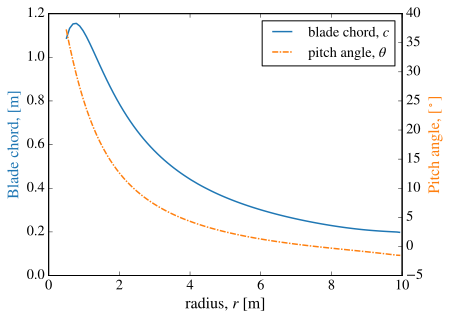

In [154]:
V1a = 2.5
Ω = 24.0 * np.pi / 30.0
Z = 3

α  = 5 * deg2rad
CL = 1.00
CD = 0.05

EE_factor = 2.0 * np.pi / Z * V1a / Ω / CL

θ_vec = []
r_vec = []
c_vec = []

for λr, a, ap, ϕ, EE in zip( λr_vec, a_vec, ap_vec, ϕ_vec, EE_vec ):

    θ = ϕ - α
    r = λr * V1a / Ω
    c = EE * EE_factor

    θ_vec.append( θ )
    r_vec.append( r )
    c_vec.append( c )

ax1 = mpl.gca()
ax1.plot( r_vec, c_vec, mut.linecolors[0], label="blade chord, $c$" )
ax1.set_ylabel( "Blade chord, [m]", color=mut.linecolors[0] )
ax1.set_xlabel( r"radius, $r$ [m]")
ax2 = mpl.gca().twinx()
ax2.plot( r_vec, np.array( θ_vec ) * rad2deg, mut.linecolors[1], \
          dashes=mut.linestyles[2], label=r'pitch angle, $\theta$' )
ax2.tick_params(axis='y' )
ax2.set_ylabel( "Pitch angle, [$^\circ$]", color=mut.linecolors[1] )

lines1, labels1 = ax1.get_legend_handles_labels()
lines2, labels2 = ax2.get_legend_handles_labels()
ax2.legend(lines1 + lines2, labels1 + labels2, loc='upper right' );